<a href="https://colab.research.google.com/github/shrutikamokashi/Covid19_Projects/blob/master/Project_Covid19_Updated_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install xgboost --user

In [0]:
#!pip install folium --user

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker  #ticker control
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import folium
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
mms = MinMaxScaler()

In [0]:
cluster_data = pd.read_csv("Countries_usefulFeatures.csv")
data = pd.read_csv("train_w4.csv")
data2 = pd.read_csv("train_w5.csv")
country_geo = "world-countries.json"
fd_i = pd.read_csv("hfi_cc_2019.csv")

testing = pd.read_csv("tested_worldwide.csv")
max_d_test=testing.groupby(["Country_Region"]).agg({"daily_tested":"max"}).reset_index()

In [0]:
r = {
     'Czech Republic': 'Czechia',
     'DR Congo': 'Congo (Brazzaville)',
     'Democratic Republic of the Congo': 'Congo (Kinshasa)',
     'Ivory Coast': "Cote d'Ivoire",
     'Palestine': 'West Bank and Gaza',
     'South Korea': 'Korea, South',
     'Taiwan': 'Taiwan*',
     'United States': 'US',
    }

In [6]:
max_d_test.Country_Region=max_d_test.Country_Region.replace(to_replace=r)
fd_i = fd_i[fd_i.year==2017]
fd_i = fd_i[["ISO_code","pf_score","hf_score"]]
cluster_data.columns
fd_i

,ISO_code,pf_score,hf_score
0,ALB,8.01,7.84
1,DZA,5.2,4.99
2,AGO,5.98,5.4
3,ARG,8.04,6.86
4,ARM,7.15,7.42
...,...,...,...
157,VEN,5.03,3.8
158,VNM,6.31,6.29
159,YEM,2.75,4.3
160,ZMB,6.13,6.49


In [7]:
data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [8]:
cluster_data.head()

,Country_Region,Population_Size,Tourism,Date_FirstFatality,Date_FirstConfirmedCase,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Country_Code
0,Afghanistan,37172386,14000,2020-03-23,2020-02-25,33.939110,67.709953,17.3,2020-03-24,Full,AFG
1,Albania,2866376,5340000,2020-03-12,2020-03-10,41.153332,20.168331,36.2,2020-03-08,Full,ALB
2,Algeria,42228429,2657000,2020-03-13,2020-02-26,28.033886,1.659626,27.5,2020-03-24,Full,DZA
3,Andorra,77006,3042000,2020-03-23,2020-03-03,42.546245,1.601554,37.0,2020-03-16,Full,AND
4,Angola,30809762,218000,2020-03-30,2020-03-21,-11.202692,17.873887,16.4,NaN,NaN,AGO


Clustering the data with those 5 columns 'Population_Size', 'Tourism', 'Date_FirstFatality','Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age'

In [0]:
data_to_cluster = cluster_data.copy()
data_to_cluster = data_to_cluster[["Country_Region","Population_Size","Tourism","Date_FirstFatality","Date_FirstConfirmedCase","Latitude","Longtitude","Mean_Age"]]

In [10]:
data_to_cluster.isnull().sum()

Country_Region              0
Population_Size             0
Tourism                     0
Date_FirstFatality         28
Date_FirstConfirmedCase     0
Latitude                    0
Longtitude                  0
Mean_Age                    0
dtype: int64

In [0]:
data_to_cluster.Date_FirstFatality.fillna("2222-11-11",inplace=True)
data_to_cluster.Date_FirstFatality=pd.to_datetime(data_to_cluster.Date_FirstFatality)
data_to_cluster.Date_FirstFatality = data_to_cluster.Date_FirstFatality.astype(np.int64) // 10**9
data_to_cluster.Date_FirstConfirmedCase=pd.to_datetime(data_to_cluster.Date_FirstConfirmedCase)
data_to_cluster.Date_FirstConfirmedCase = data_to_cluster.Date_FirstConfirmedCase.astype(np.int64) // 10**9
data_to_cluster.drop(["Country_Region"],axis=1,inplace=True)
mms.fit(data_to_cluster)
data_transformed = mms.transform(data_to_cluster)

Checking for the optimal K in Kmeans Clustering

In [0]:
Sum_of_squared_distances = []
K = range(1,90)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

In [0]:
km = KMeans(n_clusters=55,random_state=1995)
km = km.fit(data_transformed)
cluster_data["cluster"] = km.labels_
data.drop("Province_State",axis=1,inplace=True)
data = pd.merge(data,cluster_data,on='Country_Region',how="left")

Creating other useful columns


In [15]:
data.columns

Index(['Id', 'Country_Region', 'Date', 'ConfirmedCases', 'Fatalities',
       'Population_Size', 'Tourism', 'Date_FirstFatality',
       'Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age',
       'Lockdown_Date', 'Lockdown_Type', 'Country_Code', 'cluster'],
      dtype='object')

In [0]:
temp_data = data.groupby(["Country_Region","Date"]).agg({"ConfirmedCases":"sum","Fatalities":"sum"}).reset_index()
temp_data.columns = ["Country_Region","Date","ConfirmedCases_i","Fatalities_i"]
data.drop_duplicates(["Country_Region","Date"],inplace=True)
data = pd.merge(data,temp_data,on=['Country_Region',"Date"],how="left")
data.drop(["ConfirmedCases","Fatalities"],axis=1,inplace=True)
data.rename(columns={"ConfirmedCases_i":"ConfirmedCases","Fatalities_i":"Fatalities","clusters":"cluster"},inplace=True)

Fatalities percentage



In [17]:
data.Date_FirstFatality.fillna("2222-11-11",inplace=True)
data.isnull().sum()

Id                            0
Country_Region                0
Date                          0
Population_Size               0
Tourism                       0
Date_FirstFatality            0
Date_FirstConfirmedCase       0
Latitude                      0
Longtitude                    0
Mean_Age                      0
Lockdown_Date              3630
Lockdown_Type              3630
Country_Code                  0
cluster                       0
ConfirmedCases                0
Fatalities                    0
dtype: int64

In [0]:
data["Fatalities_rate"]=(data.Fatalities * 100) / data.ConfirmedCases

#Difference between Lockdown Date and First Confirmed Case Date

data["diff_FC_LD"]=(data.Lockdown_Date.astype('datetime64') - data.Date_FirstConfirmedCase.astype('datetime64'))

In [0]:
#Difference between Lockdown Date and First Confirmed Fatality

data["diff_FF_LD"]=(data.Lockdown_Date.astype('datetime64') - data.Date_FirstFatality.astype('datetime64'))

In [0]:
tempd2=data2.loc[(data2.Target=="ConfirmedCases"),["Country_Region","Weight"]]
tempd2["Weight_F"] =  data2.loc[(data2.Target=="Fatalities"),["Weight"]].values
tempd2.columns = ["Country_Region","Weight_C","Weight_F"]
tempd2=tempd2.drop_duplicates(["Country_Region"])
data = pd.merge(data,tempd2[["Country_Region","Weight_C","Weight_F"]],on=['Country_Region'],how="left")
fd_i.columns = ["Country_Code","pf_score","hf_score"]
data = pd.merge(data,max_d_test[["Country_Region","daily_tested"]],on=['Country_Region'],how="left")
data=pd.merge(data,fd_i[["Country_Code","pf_score","hf_score"]],on=['Country_Code'],how="left")
data.daily_tested.fillna(data.loc[data.daily_tested>100,"daily_tested"].min(),inplace=True)
data.hf_score.fillna(data.hf_score.median(),inplace=True)
data.pf_score.fillna(data.pf_score.median(),inplace=True)

In [21]:
testing = pd.read_csv('tested_worldwide.csv', delimiter=',') 
testing.dataframeName = 'tested_worldwide.csv'
nRow, nCol = testing.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8473 rows and 12 columns


In [22]:
testing[testing.Country_Region=='United States']
testing_on=testing[testing.Province_State=='Massachusetts'].dropna(subset=['daily_tested'])
testing_on=testing_on.assign(daily_rate=testing_on.daily_positive/testing_on.daily_tested*100)
#df1_on['daily_pos_rate']=df1_on.daily_positive/df1_on.daily_tested*100
testing_on.daily_rate.replace(np.inf, 0, inplace=True)
testing_on.daily_rate.fillna(0, inplace=True)
testing_on.reset_index(drop=True, inplace=True)
testing_on.head()


,Date,Country_Region,Province_State,positive,active,hospitalized,hospitalizedCurr,recovered,death,total_tested,daily_tested,daily_positive,daily_rate
0,2020-03-13,United States,Massachusetts,23.0,NaN,NaN,NaN,NaN,0.0,23.0,15.0,15.0,100.000000
1,2020-03-14,United States,Massachusetts,38.0,NaN,NaN,NaN,NaN,0.0,38.0,15.0,15.0,100.000000
2,2020-03-15,United States,Massachusetts,64.0,NaN,NaN,NaN,NaN,0.0,648.0,610.0,26.0,4.262295
3,2020-03-16,United States,Massachusetts,97.0,NaN,NaN,NaN,NaN,0.0,1296.0,648.0,33.0,5.092593
4,2020-03-17,United States,Massachusetts,118.0,NaN,NaN,NaN,NaN,0.0,1751.0,455.0,21.0,4.615385


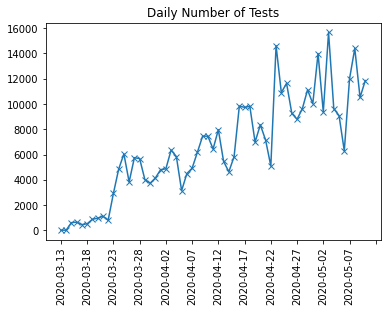

In [23]:
fig, ax = plt.subplots()
ax.plot(testing_on.Date, testing_on.daily_tested,'x-')
plt.title('Daily Number of Tests')
plt.xticks(rotation=90)
loc = plticker.MultipleLocator(base=5.0) 
ax.xaxis.set_major_locator(loc)
plt.show()


The testing isn't consistent, but at least the overall trend line is up.

But the question is: is testing keep up with the increase in infections? If it is, then the rate of daily positive tests should stay flat. However, from the results below, the answer seems to be no. Towards the end of March, the percentage of tests that returned positive skyrocketed

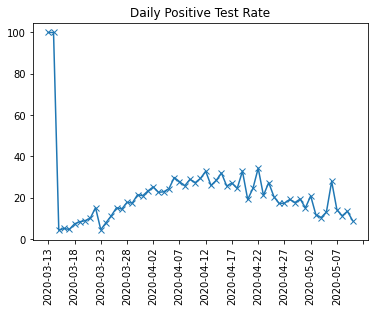

In [24]:
fig, ax = plt.subplots()
ax.plot(testing_on.Date, testing_on.daily_rate,'x-')
plt.title('Daily Positive Test Rate')
plt.xticks(rotation=90)
loc = plticker.MultipleLocator(base=5.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

Recently, South Korea was often mentioned as an example of effective pandemic control through mass testing. Their postive test rate was between 2-3% of all tests.

Ontario had a similar rate up until 3rd week of March, before positive test rates shot up. As we can see below, up until the 3rd week of March, positive test rate was stable around the 2% mark.

Let's set the average positive test rate from March 15 to March 25 as the baseline positive test rate. If testing was ramped up such that the positive test rate was maintained at the baseline rate, then the testing results would paint the correct picture of the pandemic's progress for us.

If testing was inadequate, I can scale up the reported positive cases to reflect what I think is the actual number by defining the scale factor.

To keep things simple, I assumed a linear relationship between the positive test rate and the scale factor. Say in tomorrow's batch of data, the positive test rate doubled from 2% (the baseline) to 4% and 50 people were reported as infected, then I will double the number of infected to 100 as my estimate of actual number of people infected. If instead the positive test rate tripled from 2% (the baseline) to 6% and 50 people were reported as infected, then I will triple the number of infected to 150 as my estimate of actual number of people infected.

ScaleFactor=DailyPositiveRate/BaselinePositiveRate
 
TrueInfection=ReportedInfection×ScaleFactor
 
Admittedly this is a big assumption. Further improvements can be made here

In [25]:
base_pct=testing_on['daily_rate'].iloc[19:30].mean() # calculate baseline
base_pct
testing_on=testing_on.assign(scale_factor=testing_on.daily_rate/base_pct) # define scale factor
testing_on.drop(testing_on.index[range(19)],inplace=True)  #drop the first 19 rows, where no significant testing took place
testing_on=testing_on.assign(daily_positive_exp=round(testing_on.daily_positive*testing_on.scale_factor), positive_exp=np.nan) #expected daily positive cases
testing_on.loc[19,'positive_exp']=testing_on.loc[19,'positive']
for i  in range(1,len(testing_on)):
    testing_on.loc[19+i,'positive_exp']=testing_on.loc[18+i,'positive_exp']+testing_on.loc[19+i, 'daily_positive_exp'] #expected total positive cases
testing_on

,Date,Country_Region,Province_State,positive,active,hospitalized,hospitalizedCurr,recovered,death,total_tested,daily_tested,daily_positive,daily_rate,scale_factor,daily_positive_exp,positive_exp
19,2020-04-01,United States,Massachusetts,7639.0,NaN,682.0,NaN,NaN,187.0,51764.0,4803.0,1118.0,23.277118,0.891850,997.0,7639.0
20,2020-04-02,United States,Massachusetts,8867.0,NaN,813.0,NaN,NaN,229.0,56634.0,4870.0,1228.0,25.215606,0.966122,1186.0,8825.0
21,2020-04-03,United States,Massachusetts,10303.0,NaN,966.0,NaN,NaN,265.0,62988.0,6354.0,1436.0,22.599937,0.865904,1243.0,10068.0
22,2020-04-04,United States,Massachusetts,11637.0,NaN,1370.0,1370.0,NaN,304.0,68828.0,5840.0,1334.0,22.842466,0.875196,1168.0,11236.0
23,2020-04-05,United States,Massachusetts,12402.0,NaN,1632.0,1632.0,NaN,370.0,71967.0,3139.0,765.0,24.370819,0.933754,714.0,11950.0
24,2020-04-06,United States,Massachusetts,13739.0,NaN,1667.0,1667.0,NaN,448.0,76459.0,4492.0,1337.0,29.764025,1.140392,1525.0,13475.0
25,2020-04-07,United States,Massachusetts,15104.0,NaN,1831.0,1831.0,NaN,515.0,81374.0,4915.0,1365.0,27.772126,1.064073,1452.0,14927.0
26,2020-04-08,United States,Massachusetts,16692.0,NaN,2119.0,2119.0,NaN,615.0,87541.0,6167.0,1588.0,25.749959,0.986595,1567.0,16494.0
27,2020-04-09,United States,Massachusetts,18843.0,NaN,2302.0,2302.0,NaN,725.0,94989.0,7448.0,2151.0,28.880236,1.106530,2380.0,18874.0
28,2020-04-10,United States,Massachusetts,20878.0,NaN,2435.0,2435.0,NaN,832.0,102442.0,7453.0,2035.0,27.304441,1.046154,2129.0,21003.0


Results
Let's compare the estimated infection based on tests vs. the reported number

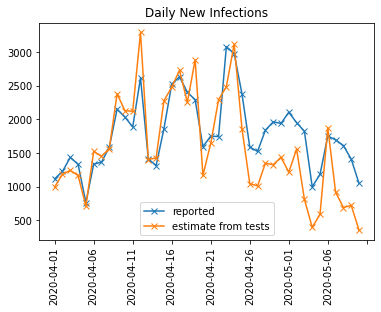

In [26]:
fig, ax = plt.subplots()
ax.plot(testing_on.Date, testing_on.daily_positive,'x-', label='reported')
ax.plot(testing_on.Date, testing_on.daily_positive_exp,'x-', label='estimate from tests')
plt.title('Daily New Infections')
plt.xticks(rotation=90)
loc = plticker.MultipleLocator(base=5.0) 
ax.xaxis.set_major_locator(loc)
plt.legend()
plt.show()

Line Plots

Checking the clusters

5 first Clusters

Line plot with Date and ConfirmedCases

Line plot with Date and Fatalities



In [27]:
for i in data.cluster.unique()[:5]:
    test_df2= data[["Country_Region","Date","Fatalities","cluster"]]
    test_df2=test_df2[ (test_df2.cluster==i) & (test_df2.Date > "2020-03-02") ]
    fig = px.bar(test_df2, x="Date", y="Fatalities", color='Country_Region')
    fig.show()

Maps

Fatalities_rate

In [28]:
temp =data[(data.Date == max(data.Date)) ]
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)


for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Fatalities_rate and Mean_Age


In [29]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'Mean_Age'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='BuGn', fill_opacity=0.7, line_opacity=0.1,
             legend_name="Mean_Age")

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Number of tests per day by country


In [30]:
temp.daily_tested = temp.daily_tested.astype("float")
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'daily_tested'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="daily_tested",
             threshold_scale=[0.0, 1000, 5000.0, 10000.0,50000.0,100000.0, 318720.0]
            )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='green', fill='green',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['ConfirmedCases']*1.1)).add_to(m)

m

In [0]:
temp.to_csv("temp.csv",index=False)

Fatalities_rate and the difference between lockDown Date and FirstConfirmedCase


In [0]:
temp.diff_FC_LD.replace({np.NAN:"62"},inplace=True)
temp.diff_FF_LD.replace({np.NAN:"42"},inplace=True)
temp.diff_FC_LD=temp.diff_FC_LD.astype(str)
temp.diff_FF_LD=temp.diff_FF_LD.astype(str)
temp.diff_FC_LD=temp.diff_FC_LD.str[:2]
temp.diff_FF_LD=temp.diff_FF_LD.str[:2]
temp.diff_FC_LD = temp.diff_FC_LD.astype(int)
temp.diff_FF_LD = temp.diff_FF_LD.astype(int)

Fatalities_rate and Daily testing


In [33]:
fig = px.scatter(data[(data.daily_tested>200) & (data.Date == max(data.Date)) ],
                 x='daily_tested', y='Fatalities', color='Fatalities', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Predicting the ConfirmCases From Fatalities

In [0]:
data.sort_values(["Country_Region"],inplace=True)

In [35]:
tmp_df = pd.DataFrame([data.Country_Region.unique()]).T
tmp_df.columns =["Country_Region"]
tmp_df=pd.merge(tmp_df, data.loc[(data.Date == max(data.Date)),["ConfirmedCases","Country_Region"]],how="left",on="Country_Region")
tmp_df[tmp_df.Country_Region.isin(["Morocco","Egypt","Algeria","Tunisia","France","Spain","Italy","Korea, South"])]

,Country_Region,ConfirmedCases
2,Algeria,5723.0
53,Egypt,9400.0
62,France,177094.0
85,Italy,219070.0
91,"Korea, South",10909.0
117,Morocco,6063.0
157,Spain,224350.0
170,Tunisia,1032.0


In [0]:
tmp_df1 = tmp_df.sort_values(by=['ConfirmedCases'])

In [37]:
positions = []
for x in tmp_df1['Country_Region'].tail():
    x.rstrip("\n");
    positions.append(x)
listToStr = ','.join([str(elem) for elem in positions]) 
positions[-1]
listToStr

'Russia,Italy,United Kingdom,Spain,US'

In [0]:
temp1 = temp.sort_values(by=['daily_tested'])

In [39]:
#script, pos_file, output = argv
most_test = []
for x in temp1['Country_Region'].tail():
    x.rstrip("\n");
    most_test.append(x)
listToStrC = ','.join([str(elem) for elem in most_test]) 
most_test[-1]
listToStrC

'Germany,India,Spain,Russia,US'

In [40]:
fatalities = []
for x in temp.sort_values('Fatalities')['Country_Region'].tail():
    x.rstrip("\n");
    fatalities.append(x)
listToStrD = ','.join([str(elem) for elem in fatalities]) 
listToStrD

'France,Spain,Italy,United Kingdom,US'

In [41]:
!pip install nltk
import nltk

In [42]:
!python --version

Python 3.6.9


In [43]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import random

In [45]:
#!pip install keras
#!pip3 install keras==2.3.0
#!pip install --user tensorflow==1.14.0
#from tensorflow import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD


Using TensorFlow backend.


In [0]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('WHO.json').read()
#type(data_file)
data_file = data_file.replace('top_affected_countries', listToStr)
data_file = data_file.replace('highest_cases_country', positions[-1])
data_file = data_file.replace('top_testing_countries', listToStrC)
data_file = data_file.replace('highest_testing_countries', most_test[-1])
data_file = data_file.replace('top_death_countries ', listToStrD)
data_file = data_file.replace('highest_death_country', fatalities[-1])

In [0]:
intents = json.loads(data_file)
with open('WHO_up.json', 'w') as json_file:
    json.dump(intents, json_file)

In [0]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent['tag']))

        # adding classes to our class list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [49]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")

print (len(classes), "classes", classes)

print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

296 documents
50 classes ['Germany,India,Spain,Russia,US', 'adverse_drug', 'animals_corona', 'ans_admitted', 'antibiotics_for_corona', 'any_other_querie', 'ask_and_get_info', 'blood_pressure', 'blood_pressure_search', 'cause_corona', 'corona_and_other_flu', 'corona_infected_ans', 'corona_infected_que', 'corona_synonym', 'defination_corona', 'emergency_symptoms', 'faq_symptoms_question', 'first_symptom_quetion', 'goodbye', 'greeting', 'handle_answer', 'hospital_search', 'incubation_corona', 'location_identifier', 'mask_and_corona', 'matching_symptoms', 'options', 'patient_age', 'patient_background', 'person_admitted_q', 'pharmacy_search', 'prevention_corona', 'query', 'query_newborn', 'query_pregnancy', 'query_public', 'query_smoking', 'reason_behind_corona', 'risk_catching_corona', 'sars_and_corona', 'send_the_correct_response', 'spread_corona', 'starting_place_corona', 'starting_time_corona', 'survival_corona', 'thanks', 'top_cases', 'top_deaths_countries', 'vaccine_for_corona', 'worr

In [50]:
# initializing training data
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


In [51]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("model created")

Epoch 1/200
296/296 [==============================] - 0s 607us/step - loss: 3.8341 - accuracy: 0.0709
Epoch 2/200
296/296 [==============================] - 0s 287us/step - loss: 3.5739 - accuracy: 0.1149
Epoch 3/200
296/296 [==============================] - 0s 278us/step - loss: 3.4400 - accuracy: 0.1486
Epoch 4/200
296/296 [==============================] - 0s 274us/step - loss: 3.2003 - accuracy: 0.1892
Epoch 5/200
296/296 [==============================] - 0s 291us/step - loss: 3.0136 - accuracy: 0.2703
Epoch 6/200
296/296 [==============================] - 0s 317us/step - loss: 2.7987 - accuracy: 0.3209
Epoch 7/200
296/296 [==============================] - 0s 308us/step - loss: 2.6274 - accuracy: 0.3277
Epoch 8/200
296/296 [==============================] - 0s 299us/step - loss: 2.3824 - accuracy: 0.3953
Epoch 9/200
296/296 [==============================] - 0s 287us/step - loss: 2.1711 - accuracy: 0.4291
Epoch 10/200
296/296 [==============================] - 0s 278us/step - l

In [0]:
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('WHO_up.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [0]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res


In [54]:
#Creating GUI with tkinter
import tkinter
from tkinter import *


def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="#442265", font=("Verdana", 12 ))

        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')

        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)


base = Tk()
base.title("Covid-19 Assistant")
base.geometry("400x500")
base.resizable(width=FALSE, height=FALSE)

#Create Chat window
ChatLog = Text(base, bd=0, bg="white", height="8", width="50", font="Arial",)

ChatLog.config(state=DISABLED)

#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set

#Create Button to send message
SendButton = Button(base, font=("Verdana",12,'bold'), text="Send", width="12", height=5,
                    bd=0, bg="#32de97", activebackground="#3c9d9b",fg='#ffffff',
                    command= send )

#Create the box to enter message
EntryBox = Text(base, bd=0, bg="white",width="29", height="5", font="Arial")
#EntryBox.bind("<Return>", send)


#Place all components on the screen
scrollbar.place(x=376,y=6, height=386)
ChatLog.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)

base.mainloop()

TclError: ignored